In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [28]:
class EchoStateNetwork(nn.Module):
    def __init__(self, reservoir_size=130, tau=1.0, dt=0.1):
        super(EchoStateNetwork, self).__init__()

        self.input_weights = torch.rand(reservoir_size)  # Uniform distribution from 0 to 1
        self.tau = tau
        self.dt = dt

        self.reservoir_state = torch.zeros(reservoir_size)

        # Normal distribution with zero mean and unit variance
        self.reservoir_weights = torch.randn(reservoir_size, reservoir_size) 

        # Enforce 10% sparsity on input_weights
        mask = torch.rand(self.input_weights.shape) < 0.1
        self.input_weights = self.input_weights * mask.float()

        # Enforce 10% sparsity on reservoir_weights
        mask = torch.rand(self.reservoir_weights.shape) < 0.1
        self.reservoir_weights = self.reservoir_weights * mask.float()

        # Compute M before adjusting spectral radius
        M = (1 - self.dt/self.tau) * torch.eye(reservoir_size) + self.dt/self.tau * self.reservoir_weights
        
        # Calculate spectral radius of M
        eigs = torch.linalg.eig(M)[0]  # Calculate the eigenvalues
        spectral_radius = torch.max(torch.abs(eigs[:, 0]))  # Find the maximum absolute eigenvalue

        # Rescale M to have spectral radius of 1.1
        M = M / spectral_radius * 1.1

        # Assign back to reservoir_weights
        self.reservoir_weights = (M - (1 - self.dt/self.tau) * torch.eye(reservoir_size)) * self.tau / self.dt


    def forward(self, x):
        dxdt = (-self.reservoir_state + 
                self.input_weights * x + 
                self.reservoir_weights @ torch.tanh(self.reservoir_state))

        self.reservoir_state += self.dt * dxdt / self.tau
        return self.reservoir_state

    def generate_responses(self, X):
        responses = []
        for x in X:
            self.forward(x)
            responses.append(self.reservoir_state.detach().clone())
        return torch.stack(responses)


# Create an instance of the model
model = EchoStateNetwork()

# Generate random input data
X = torch.randn(100, 1)  # For example, 100 random Gaussian white noise inputs

# Get the neuron responses for the inputs
responses = model.generate_responses(X)

# Print the responses
print(responses)


IndexError: too many indices for tensor of dimension 1

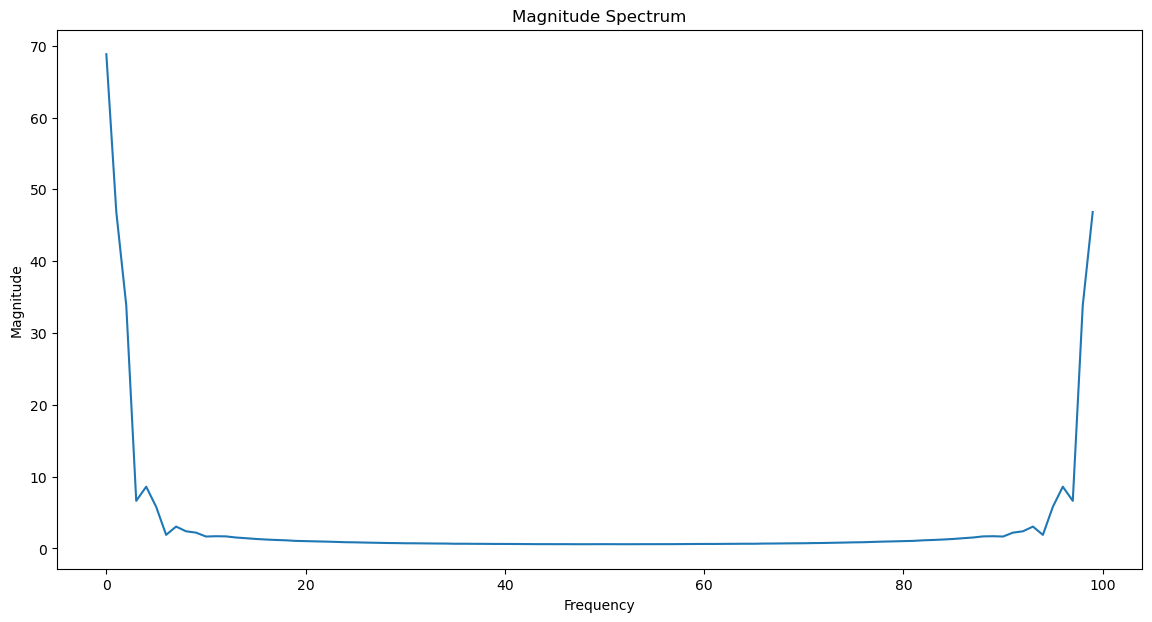

In [25]:
# Calculate the average response of all neurons across all time steps
avg_response = responses.mean(dim=1)

# Perform FFT
# fft_result = torch.fft.fft(avg_response)
fft_result = torch.fft.fft(responses[:,2])

# Calculate the absolute value of the FFT result to get the magnitude spectrum
magnitude_spectrum = torch.abs(fft_result)

# Plot the magnitude spectrum
plt.figure(figsize=(14, 7))
plt.plot(magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


In [15]:
magnitude_spectrum.size()

torch.Size([100])